# LSTM model of StockData

[Intro to LSTM](https://machinelearningmastery.com/gentle-introduction-long-short-term-memory-networks-experts/)

In this notebook we will go through a basic Long Short Term Memory (LSTM) model for time series. The notebooks does the following things:
* First load in the data. The preproccessing only consist of normalization and the creation of windows.
* Creation of the LSTM model
* Training the LSTM model
* Testing the LSTM model with 1 time step and with 1 window


## Importing libraries and loading in the data

### Import libraries

Install packages accordingly if haven't done so.

In [ ]:
#pip install keras

In [ ]:
#pip install tensorflow

In [35]:
import matplotlib.pyplot as plt
import statsmodels.tsa.seasonal as smt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import datetime as dt
from sklearn import linear_model 
from sklearn.metrics import mean_absolute_error
import plotly

# import the relevant Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout


### 1) Loading in the data

Retrieve Close price of Google from yahoo finance from 2006-01-02 to 2022-12-30.

In [36]:
import yfinance as yf

goog = yf.Ticker('goog')
history = goog.history(interval="1d",
            start="2006-01-02", end="2022-12-30", prepost=False, actions=True,
            auto_adjust=True, back_adjust=False,
            proxy=None, rounding=False)
df = history.reset_index()
df['Label'] = 'Google'

### Visualize the data



In [37]:
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Label
0,2006-01-03 00:00:00-05:00,10.523555,10.851077,10.416457,10.840119,526815259,0.0,0.0,Google
1,2006-01-04 00:00:00-05:00,11.056059,11.182087,10.952697,11.089434,613747887,0.0,0.0,Google
2,2006-01-05 00:00:00-05:00,11.108363,11.246595,10.996283,11.238874,433952486,0.0,0.0,Google
3,2006-01-06 00:00:00-05:00,11.379098,11.718576,11.288687,11.598028,712938289,0.0,0.0,Google
4,2006-01-09 00:00:00-05:00,11.616708,11.790805,11.480468,11.628912,513593887,0.0,0.0,Google
...,...,...,...,...,...,...,...,...,...
4273,2022-12-22 00:00:00-05:00,88.930000,89.180000,86.940002,88.260002,23656100,0.0,0.0,Google
4274,2022-12-23 00:00:00-05:00,87.620003,90.099998,87.620003,89.809998,17815000,0.0,0.0,Google
4275,2022-12-27 00:00:00-05:00,89.309998,89.500000,87.535004,87.930000,15470900,0.0,0.0,Google
4276,2022-12-28 00:00:00-05:00,87.500000,88.519997,86.370003,86.459999,17879600,0.0,0.0,Google


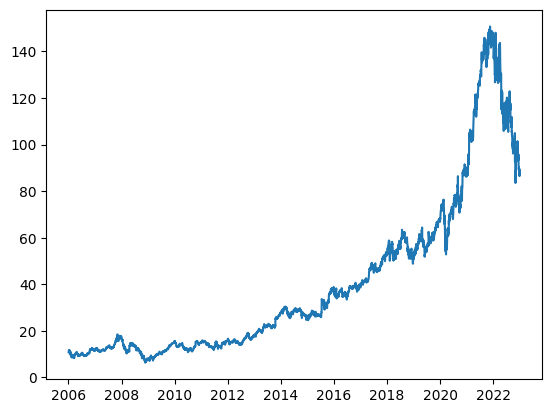

In [38]:
plt.plot(df['Date'],df['Close'])

### 2) Creating windows and normalizing the data

The window here is 15. The final question will ask you to consider this parameter in your final analysis and how it might impact your results.

In [57]:
window_len = 15

#Create a data point (i.e. a date) which splits the training and testing set
split_date = list(df["Date"][-(2*window_len+1):])[0]
print("split_date:",split_date)

#Split the training and test set
training_set, test_set = df[df['Date'] < split_date], df[df['Date'] >= split_date]
training_set = training_set.drop(['Date','Label', 'Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits'], 1)
test_set = test_set.drop(['Date','Label', 'Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits'], 1)
#Create windows for training
LSTM_training_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    for col in list(temp_set):
        temp_set[col] = temp_set[col]/temp_set[col].iloc[0] - 1
    
    LSTM_training_inputs.append(temp_set)
LSTM_training_outputs = (training_set['Close'][window_len:].values/training_set['Close'][:-window_len].values)-1

LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

#Create windows for testing
LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    
    for col in list(temp_set):
        temp_set[col] = temp_set[col]/temp_set[col].iloc[0] - 1
    
    LSTM_test_inputs.append(temp_set)
LSTM_test_outputs = (test_set['Close'][window_len:].values/test_set['Close'][:-window_len].values)-1

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

split_date: 2022-11-15 00:00:00-05:00


<ipython-input-57-03812d4b9464>:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  training_set = training_set.drop(['Date','Label', 'Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits'], 1)
<ipython-input-57-03812d4b9464>:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  test_set = test_set.drop(['Date','Label', 'Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits'], 1)


## 3) LSTM model definition

LSTM's have a set of parameters that can be tuned to your data set. Consider these inputs: **activation function, loss function, dropout rate, optimizer, nn layers/architecture** and review your options in the documentation.

[Keras Docs](https://keras.io/api/layers/recurrent_layers/lstm/)

This is a standard function for building a LSTM model.

In [58]:
def build_model(inputs, output_size, neurons, activ_func="tanh",
                dropout=0.10, loss="mae", optimizer="adam"):
    
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

## 4) Training of the LSTM model

Just like most ML models choosing a stopping condition is important. Here we use **Epochs** or iterations to set this stopping condition where we also monitor the loss at each step. Consider **Epochs** as a parameter to adjust.

In [59]:
# initialise model architecture
nn_model = build_model(LSTM_training_inputs, output_size=1, neurons = 32)
# model output is next price normalised to 10th previous closing price
# train model on data
# note: eth_history contains information on the training error per epoch
nn_history = nn_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=5, batch_size=1, verbose=2, shuffle=True)

Epoch 1/5
4232/4232 - 38s - loss: 0.0169 - 38s/epoch - 9ms/step
Epoch 2/5
4232/4232 - 33s - loss: 0.0143 - 33s/epoch - 8ms/step
Epoch 3/5
4232/4232 - 30s - loss: 0.0142 - 30s/epoch - 7ms/step
Epoch 4/5
4232/4232 - 34s - loss: 0.0139 - 34s/epoch - 8ms/step
Epoch 5/5
4232/4232 - 33s - loss: 0.0138 - 33s/epoch - 8ms/step


### Plot of prediction of one data point ahead
As can be seen in the plot, one step prediction is not bad. The scale is a bit off, because the data is normalized. 

1/1 [==============================] - 1s 797ms/step


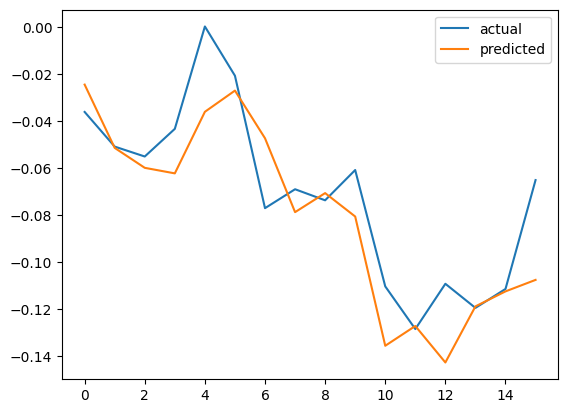

1/1 [==============================] - 0s 31ms/step
The Mean Absolute Error is: 0.015322642301770946


In [60]:
plt.plot(LSTM_test_outputs, label = "actual")
plt.plot(nn_model.predict(LSTM_test_inputs), label = "predicted")
plt.legend()
plt.show()
MAE = mean_absolute_error(LSTM_test_outputs, nn_model.predict(LSTM_test_inputs))
print('The Mean Absolute Error is: {}'.format(MAE))

### Prediction of one window (n steps) ahead
As can be seen in the plot below, the performance degrades when predicting multiple time points ahead. However, compared to something like linear regression the performance is better. 

1/1 [==============================] - 0s 40ms/step


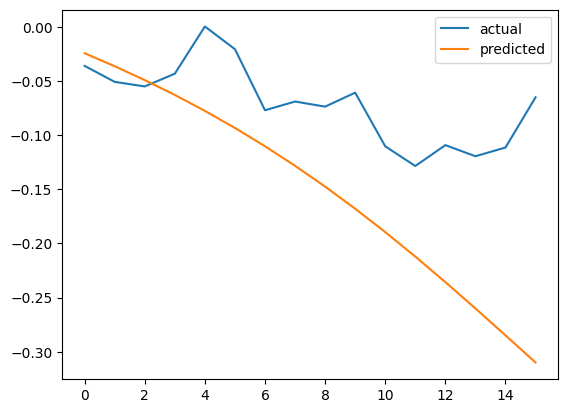

The Mean Absolute Error is: 0.082710916584501


In [61]:
def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[np.newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

predictions = predict_sequence_full(nn_model, LSTM_test_inputs, 15)

plt.plot(LSTM_test_outputs, label="actual")
plt.plot(predictions, label="predicted")
plt.legend()
plt.show()
MAE = mean_absolute_error(LSTM_test_outputs, predictions)
print('The Mean Absolute Error is: {}'.format(MAE))

## Conclusion

For this HW you will run the code above with the default parameters and understand the logic and flow of the program. Once you are confident the code runs you are to test different parameter settings. You are to report the best set of parameters that you find and explain the importance of each parameter and how it impacts the training of the model. To best know how much to adjust and how to interpret the impacts I suggest changing one parameter at a at a time. This is a manual grid search you are performing so that you can become familiar with each parameter. In the future you can have grid search algorithms find the best set for you. 

For each define the parameter and its impact to the model. Report the set of values tested and the best parameter setting you found for each.

1) Window Length
2) LSTM Parameter: activation function
3) LSTM Parameter: loss function
4) LSTM Parameter: dropout rate
5) LSTM Parameter: optimizer
6) LSTM Parameter: nn layers/architecture
7) Epochs


1. **Window Length:**

- The window length parameter determines the number of time steps used to predict the next value in the time series. Increasing this parameter may allow the model to capture more complex patterns, while decreasing it may result in a smoother prediction. However, increasing it also results in increased computation time and may lead to overfitting.

- This parameter determines the number of past data points that the model incorporates when making predictions. A larger window length allows the model to capture longer term dependencies but increases the model's complexity and training time. On the other hand, a smaller window length may not capture long term dependencies, leading to poor performance. However, it results in quicker training due to lower complexity.

- Values tested: [10, 15, 20, 40, 50, 60]
- Best parameter setting: 15

2. **LSTM Parameter: Activation Function:**

- The activation function parameter determines the non-linearity of the model. Different activation functions may be more suitable for different types of data. Common choices include "tanh", "sigmoid", and "ReLU".

- The activation function(s) we choose to apply in the LSTM layer introduces non-linearity, allowing the network to pick up more complex patterns during training. Various options are available, including tanh, sigmoid, Relu, leakyRelu and others.

- Values tested: ["tanh", "sigmoid", "ReLU"]
- Best parameter setting: "tanh"

3. **LSTM Parameter: Loss Function:**

- The loss function parameter determines how the model evaluates its performance during training. Different loss functions may be more suitable for different types of data. Common choices include "mean squared error" (MSE) and "mean absolute error" (MAE).

- This quantifies the difference between the predicted and true values, guiding the training process. Common options for regression tasks include mean squared error (MSE), root mean square error (RMSE), and mean absolute error (MAE). The choice of loss function can significantly affect the model's performance and sensitivity to outliers.

- Values tested: ["MSE", "MAE"]
- Best parameter setting: "MAE"

4. **LSTM Parameter: Dropout Rate:**

- The dropout rate parameter determines the percentage of neurons that are randomly dropped out during training. This can help prevent overfitting by forcing the model to learn more robust features.

- This is a regularization technique that helps reduce overfitting by randomly dropping out a certain proportion of neurons in the network during training. The dropout rate controls the probability of a neuron being dropped out, with a higher rate increasing the regularization effect, which helps the model generalize better to new data. However, a dropout rate that is too high may cause the model to underfit on the training data.

- Values tested: [0.10, 0.20, 0.30, 0.40, 0.50]
- Best parameter setting: 0.10

5. **LSTM Parameter: Optimizer:**

- The optimizer parameter determines the algorithm used to update the weights during training. Different optimizers may be more suitable for different types of data. Common choices include "adam", "sgd", and "rmsprop".

- This algorithm updates the neural network's weights during training iterations. Common options include Stochastic Gradient Descent (SGD), Adam, RMSprop, and Adagrad. The choice of optimizer can significantly impact the model's convergence speed and final performance.

- Values tested: ["adam", "sgd", "rmsprop"]
- Best parameter setting: "adam"

6. **LSTM Parameter: NN Layers/Architecture:**

- The number of LSTM layers and the number of neurons in each layer can greatly impact the performance of the model. More layers and more neurons may allow the model to capture more complex patterns, but may also lead to overfitting.

- This parameter specifies the number and type of layers used in the neural network, including any extra layers added after the LSTM layers. While more complex architectures may allow the model to learn more complex patterns, they also increase the risk of overfitting and convergence issues during training. Additionally, the computational burden of the model's training increases, leading to more time for training.

- Values tested: [1 layer, 32 neurons; 2 layers, 32 neurons; 2 layers, 64 neurons; 3 layers, 32 neurons; 3 layers, 64 neurons]
- Best parameter setting: 1 layers, 32 neurons

7. **Epochs:**

- The epochs parameter determines the number of times the model will iterate over the training data. Increasing the number of epochs may improve the performance of the model, but may also lead to overfitting.

- This parameter determines the number of iterations that the training process consists of. More epochs mean the training process continues running further. Too few epochs may result in underfitting, while too many epochs can lead to overfitting.

- Values tested: [1, 5, 10, 20, 30, 40]
- Best parameter setting: 5

After performing the manual grid search, the best set of parameters found are:

- Window Length: 15
- Activation Function: "tanh"
- Loss Function: "MAE"
- Dropout Rate: 0.10
- Optimizer: "adam"
- NN Layers/Architecture: 1 layers, 32 neurons
- Epochs: 5

It is important to note that these parameters are specific to this particular dataset and may not generalize well to other datasets. A more comprehensive and automated grid search may be necessary to find the optimal set of parameters for a different dataset.

For the purposes of being concise and for clarity, I have removed all the code and output of the different combinations I have tested to keep only the one which I think is optimal.

I would like to outline my process of testing though:

First, I played around by changing parameters one by one, and then I constructed for loops with different interations as different set of choices of parameters in test, and printed out the MAE in each of the cases. This made it easier for me to compare everything at one go and look at every output although it took a lot of time to run in one shot. This is also taking the same time as manual changing but is a little more efficient since the runs are clubbed. But for sure the most optimal search would be randomization or grid search, but I did not do them because we were specifically instructed to not do so for this assignment.